In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [7]:
datagen_test_eval = ImageDataGenerator(rescale=1./255)
test_eval_generator = datagen_test_eval.flow_from_directory('./data/test_eval',target_size=(96, 96), class_mode='binary', batch_size=10, shuffle=False)

Found 22017 images belonging to 2 classes.


In [8]:
with tf.device('/cpu:0'):
    model = load_model('gs_dnn_ensemble_20221023T2328/models/1_v1.hdf5')
    X_test_eval = np.concatenate([test_eval_generator .next()[0] for i in range(test_eval_generator .__len__())])
    y_test_eval = np.concatenate([test_eval_generator .next()[1] for i in range(test_eval_generator .__len__())])

    preds = model.predict(X_test_eval, batch_size=10)

In [9]:
preds_labels = (preds > 0.50).astype(int)[:,0]

In [10]:
tn, fp, fn, tp = confusion_matrix(y_test_eval, preds_labels).ravel()
acc, prec, rec, fscore = accuracy_score(y_test_eval, preds_labels), precision_score(y_test_eval, preds_labels), recall_score(y_test_eval, preds_labels), f1_score(y_test_eval, preds_labels)

title = f'Classification results: \n TP: {tp}, TN: {tn}, FN: {fn}, FP: {fp} \n ACC: {acc:.5f}, PREC: {prec:.5f}, REC: {rec:.5f}, FSCORE: {fscore:.5f} \n'

In [11]:
print(title)

Classification results: 
 TP: 12462, TN: 7713, FN: 699, FP: 1143 
 ACC: 0.91634, PREC: 0.91599, REC: 0.94689, FSCORE: 0.93118 



In [21]:
def plot_confusion_matrix(actual, predicted):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.0)
  ax.set_title('Confusion matrix')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  labels = ["non-cancerous","cancerous"]
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


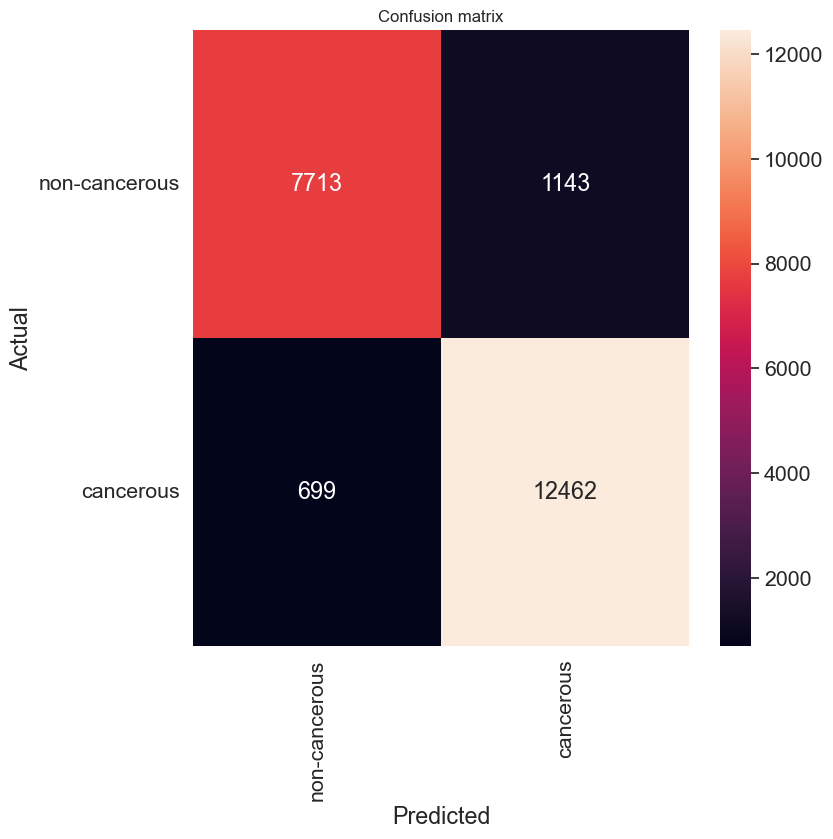

In [22]:
plot_confusion_matrix(y_test_eval, preds_labels)

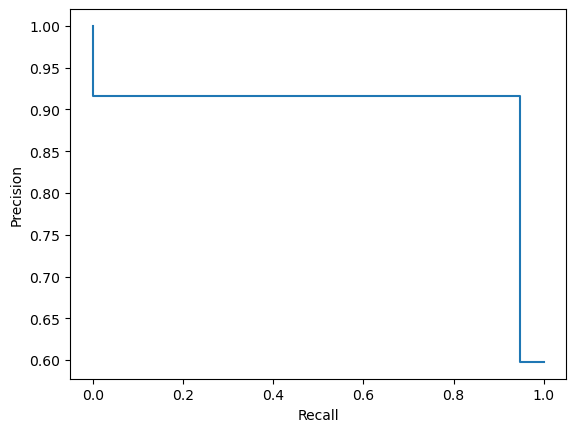

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test_eval, preds_labels)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

In [13]:
f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  1
Best F1-Score:  0.9311813494732122


### Lopulliset ennustukset testidatalla

In [23]:
datagen_test_eval = ImageDataGenerator(rescale=1./255)
test_eval_generator = datagen_test_eval.flow_from_directory('./data/unseen',target_size=(96, 96), class_mode='binary', batch_size=10, shuffle=False)

Found 21717 images belonging to 2 classes.


In [24]:
with tf.device('/cpu:0'):
    model = load_model('gs_dnn_ensemble_20221023T2328/models/1_v1.hdf5')
    X_test_eval = np.concatenate([test_eval_generator .next()[0] for i in range(test_eval_generator .__len__())])
    y_test_eval = np.concatenate([test_eval_generator .next()[1] for i in range(test_eval_generator .__len__())])

    preds = model.predict(X_test_eval, batch_size=10)

In [25]:
preds_labels = (preds > 0.5).astype(int)[:,0]

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test_eval, preds_labels).ravel()
acc, prec, rec, fscore = accuracy_score(y_test_eval, preds_labels), precision_score(y_test_eval, preds_labels), recall_score(y_test_eval, preds_labels), f1_score(y_test_eval, preds_labels)

title = f'Classification results: \n TP: {tp}, TN: {tn}, FN: {fn}, FP: {fp} \n ACC: {acc:.5f}, PREC: {prec:.5f}, REC: {rec:.5f}, FSCORE: {fscore:.5f} \n'

In [27]:
print(title)

Classification results: 
 TP: 12179, TN: 7745, FN: 666, FP: 1127 
 ACC: 0.91744, PREC: 0.91530, REC: 0.94815, FSCORE: 0.93144 



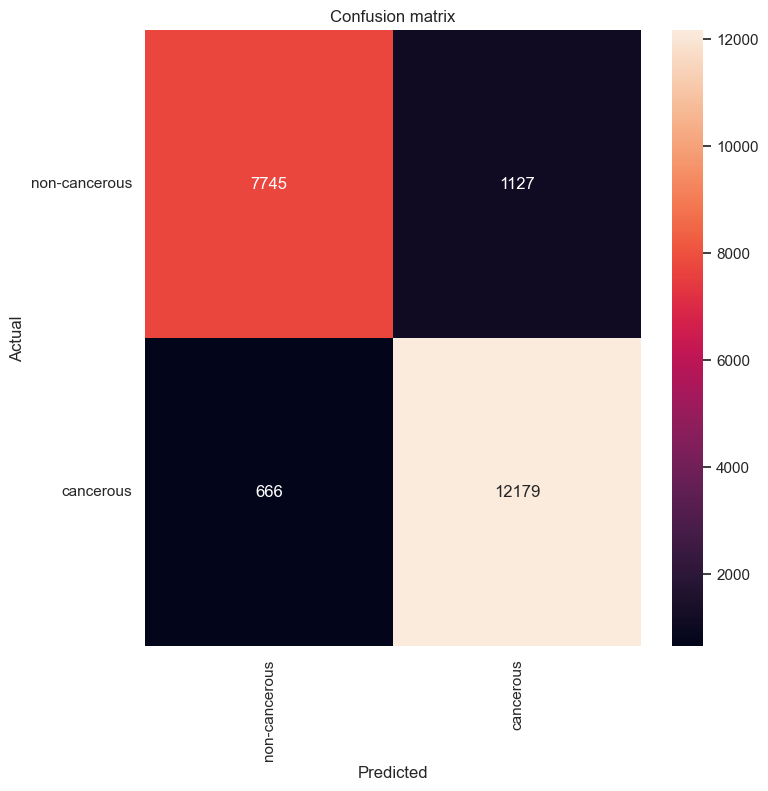

In [28]:
plot_confusion_matrix(y_test_eval, preds_labels)

### Kaggle submission file


In [6]:
kaggle_eval = ImageDataGenerator(rescale=1./255)
kaggle_eval_generator = kaggle_eval.flow_from_directory('./data/kaggle',target_size=(96, 96), class_mode='categorical', batch_size=1, shuffle=False)

Found 57458 images belonging to 1 classes.


In [7]:
model = load_model('gs_dnn_ensemble_20221023T2328/models/1_v1.hdf5')
preds = model.predict(kaggle_eval_generator, batch_size=10)

In [35]:
submission = pd.DataFrame([str(filename).removeprefix('test_images\\').replace('.tif', '') for filename in kaggle_eval_generator.filenames], columns=['id']).set_index('id')
submission['label'] = preds
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.000654
0000ec92553fda4ce39889f9226ace43cae3364e,0.607725
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.075175
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.822781
000270442cc15af719583a8172c87cd2bd9c7746,0.990946


In [36]:
df_preds.to_csv('kaggle_submission.csv')